In [9]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import wikipedia as wp
import yfinance as yf
import talib as ta

### S&P 500 stocks

In [2]:
html = wp.page("S&P 100").html().encode("UTF-8")
stocks = pd.read_html(html)[2].set_index("Symbol")
stocks = stocks.drop("GOOG")
stocks.loc["GOOGL", "Name"] = "Alphabet"
stocks = stocks.rename(index={"BRK.B": "BRK-B"})
stocks.head()

,Name,Sector
Symbol,,
AAPL,Apple Inc.,Information Technology
ABBV,AbbVie,Health Care
ABT,Abbott Laboratories,Health Care
ACN,Accenture,Information Technology
ADBE,Adobe Inc.,Information Technology


### Get the Fundamentals

In [3]:
fundamentals = [
	yf.Ticker(stock).info for stock in stocks.index
]
fundamentals = pd.DataFrame(fundamentals).set_index("symbol")
fundamentals.index = fundamentals.index.rename("Symbol")  # for consistency with the stocks dataframe
fundamentals = fundamentals[["marketCap", "trailingPE", "forwardPE", "priceToBook", "trailingEps", "forwardEps", "bookValue", "payoutRatio", "beta", "fiveYearAvgDividendYield", "52WeekChange", "averageVolume", "enterpriseToRevenue", "profitMargins"]].fillna(0)
fundamentals.head()

,marketCap,trailingPE,forwardPE,priceToBook,trailingEps,forwardEps,bookValue,payoutRatio,beta,fiveYearAvgDividendYield,52WeekChange,averageVolume,enterpriseToRevenue,profitMargins
Symbol,,,,,,,,,,,,,,
AAPL,3677070819328,40.009884,29.281986,64.576614,6.08,8.31,3.767,0.1612,1.240,0.62,0.250888,48495584,9.532,0.23971
ABBV,311431921664,61.192707,14.518704,51.636390,2.88,12.13,3.413,2.1359,0.613,4.13,0.192539,5802607,6.769,0.09223
ABT,200243412992,35.091187,22.377283,5.031816,3.29,5.16,22.944,0.6565,0.722,1.65,0.114560,5083198,5.062,0.13992
ACN,223717195776,31.268995,25.429459,7.913664,11.45,14.07,45.242,0.4510,1.245,1.36,0.074396,2468011,3.466,0.11194
ADBE,236699959296,45.568645,26.178015,16.451277,11.80,20.55,32.685,0.0000,1.299,0.12,-0.118746,2979714,11.206,0.25588


In [4]:
# Normalised the data
normalized_fundamentals = (fundamentals - fundamentals.mean()) / fundamentals.std()
normalized_fundamentals.head()

,marketCap,trailingPE,forwardPE,priceToBook,trailingEps,forwardEps,bookValue,payoutRatio,beta,fiveYearAvgDividendYield,52WeekChange,averageVolume,enterpriseToRevenue,profitMargins
Symbol,,,,,,,,,,,,,,
AAPL,4.948845,-0.002271,0.075142,2.298179,-0.218128,-0.209777,-0.100824,-0.212221,0.713554,-1.017199,-0.078923,1.259397,0.847150,0.653144
ABBV,-0.105859,0.203262,-0.227032,1.738996,-0.412155,-0.033784,-0.100832,0.372456,-0.923289,1.050662,-0.248025,-0.259000,0.315835,-0.484589
ABT,-0.272848,-0.049996,-0.066183,-0.274917,-0.387295,-0.354902,-0.100385,-0.065571,-0.638734,-0.410391,-0.474015,-0.284587,-0.012415,-0.116685
ACN,-0.237594,-0.087082,-0.003711,-0.150384,0.107473,0.055594,-0.099875,-0.126416,0.726606,-0.581240,-0.590417,-0.377597,-0.319320,-0.332536
ADBE,-0.218096,0.051665,0.011610,0.218550,0.128694,0.354138,-0.100163,-0.259950,0.867579,-1.311766,-1.150161,-0.359398,1.169054,0.777887


In [5]:
# Save it to a csv file
normalized_fundamentals.to_csv("../data/SP100/fundamentals.csv")

### Historical data

In [15]:
values = [
    yf.Ticker(stock).history(period="5y", actions=False) for stock in stocks.index
]

for idx, stock_values in enumerate(values):
    stock_values["NormClose"] = (stock_values["Close"] - stock_values["Close"].mean()) / stock_values["Close"].std()
    
    # Log returns
    stock_values["DailyLogReturn"] = np.log(1 + stock_values["Close"].pct_change())
    stock_values["ALR1W"] = stock_values["DailyLogReturn"].rolling(window=5).sum() * 5
    stock_values["ALR2W"] = stock_values["DailyLogReturn"].rolling(window=10).sum() * 5
    stock_values["ALR1M"] = stock_values["DailyLogReturn"].rolling(window=21).sum() * 21
    stock_values["ALR2M"] = stock_values["DailyLogReturn"].rolling(window=42).sum() * 21
    
    # Normalizing the standard deviation
    stock_values["DailyLogReturn"] /= stock_values["DailyLogReturn"].std()
    stock_values["ALR1W"] /= stock_values["ALR1W"].std()
    stock_values["ALR2W"] /= stock_values["ALR2W"].std()
    stock_values["ALR1M"] /= stock_values["ALR1M"].std()
    stock_values["ALR2M"] /= stock_values["ALR2M"].std()
    
    # RSI calculation
    stock_values["RSI"] = ta.RSI(stock_values["Close"], timeperiod=14) / 100
    
    # MACD calculation
    macd, macd_signal, macd_hist = ta.MACD(
        stock_values["Close"], 
        fastperiod=12, 
        slowperiod=26, 
        signalperiod=9
    )
    stock_values["MACD"] = macd
    
    # Drop unnecessary columns
    stock_values.drop(columns=["Open", "High", "Low", "Volume"], inplace=True)

# Concatenate the results into a single DataFrame
values = pd.concat(values, keys=stocks.index).dropna()
values.head(n=10)


Close  NormClose  DailyLogReturn  \
Symbol Date                                                              
AAPL   2020-02-06 00:00:00-05:00  78.821342  -1.703041        0.583288   
       2020-02-07 00:00:00-05:00  77.749947  -1.728747       -0.686463   
       2020-02-10 00:00:00-05:00  78.119232  -1.719887        0.237670   
       2020-02-11 00:00:00-05:00  77.647911  -1.731195       -0.303539   
       2020-02-12 00:00:00-05:00  79.491905  -1.686952        1.177241   
       2020-02-13 00:00:00-05:00  78.925819  -1.700534       -0.358470   
       2020-02-14 00:00:00-05:00  78.945259  -1.700067        0.012353   
       2020-02-18 00:00:00-05:00  77.499733  -1.734750       -0.926934   
       2020-02-19 00:00:00-05:00  78.622131  -1.707820        0.721212   
       2020-02-20 00:00:00-05:00  77.815559  -1.727173       -0.517223   

                                     ALR1W     ALR2W     ALR1M     ALR2M  \
Symbol Date                                                                
AAPL   2020-02-06 00:00:00-05:00  0.101644  0.324038  1.020940  1.724809   
       2020-02-07 00:00:00-05:00  0.881220  0.135476  0.669305  1.445353   
       2020-02-10 00:00:00-05:00  1.065578  0.739316  0.476199  1.605760   
       2020-02-11 00:00:00-05:00  0.116968  0.146588  0.377629  1.504608   
       2020-02-12 00:00:00-05:00  0.494848  0.194674  0.405282  1.632145   
       2020-02-13 00:00:00-05:00  0.032610  0.095214  0.481772  1.549613   
       2020-02-14 00:00:00-05:00  0.375606  0.891344  0.535636  1.436743   
       2020-02-18 00:00:00-05:00 -0.196010  0.616700  0.168763  1.134847   
       2020-02-19 00:00:00-05:00  0.306962  0.300652  0.208721  1.240568   
       2020-02-20 00:00:00-05:00 -0.524721 -0.021187  0.167063  1.173133   

                                       RSI      MACD  
Symbol Date                                           
AAPL   2020-02-06 00:00:00-05:00  0.645085  1.935510  
       2020-02-07 00:00:00-05:00  0.597961  1.860094  
       2020-02-10 00:00:00-05:00  0.608575  1.809268  
       2020-02-11 00:00:00-05:00  0.587265  1.711230  
       2020-02-12 00:00:00-05:00  0.640329  1.762018  
       2020-02-13 00:00:00-05:00  0.614222  1.736571  
       2020-02-14 00:00:00-05:00  0.614802  1.698395  
       2020-02-18 00:00:00-05:00  0.548655  1.533818  
       2020-02-19 00:00:00-05:00  0.585910  1.476932  
       2020-02-20 00:00:00-05:00  0.550730  1.351190

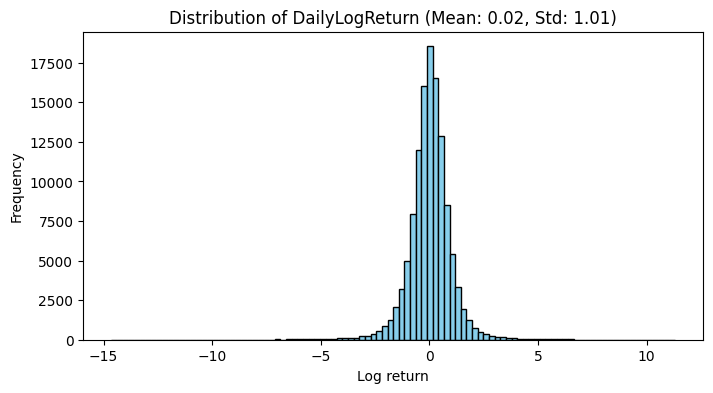

In [16]:
plt.figure(figsize=(8, 4))

column = "DailyLogReturn"
plt.hist(values[column], bins=100, color="skyblue", edgecolor="black")
plt.title(f"Distribution of {column} (Mean: {values[column].mean():.2f}, Std: {values[column].std():.2f})")
plt.xlabel("Log return")
plt.ylabel("Frequency")
plt.show()

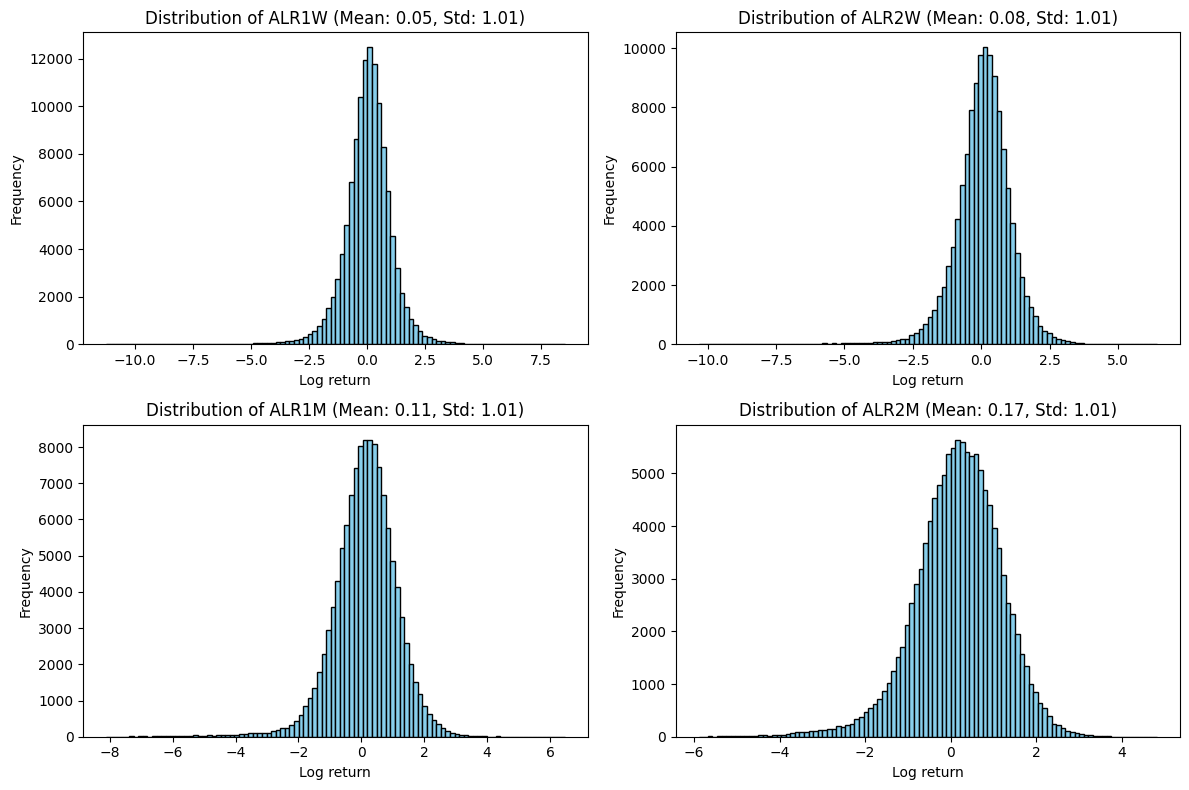

In [17]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

for idx, column in enumerate(["ALR1W", "ALR2W", "ALR1M", "ALR2M"]):
	ax = axs[idx // 2, idx % 2]
	ax.hist(values[column], bins=100, color="skyblue", edgecolor="black")
	ax.set_title(f"Distribution of {column} (Mean: {values[column].mean():.2f}, Std: {values[column].std():.2f})")
	ax.set_xlabel("Log return")
	ax.set_ylabel("Frequency")
	
plt.tight_layout()
plt.show()

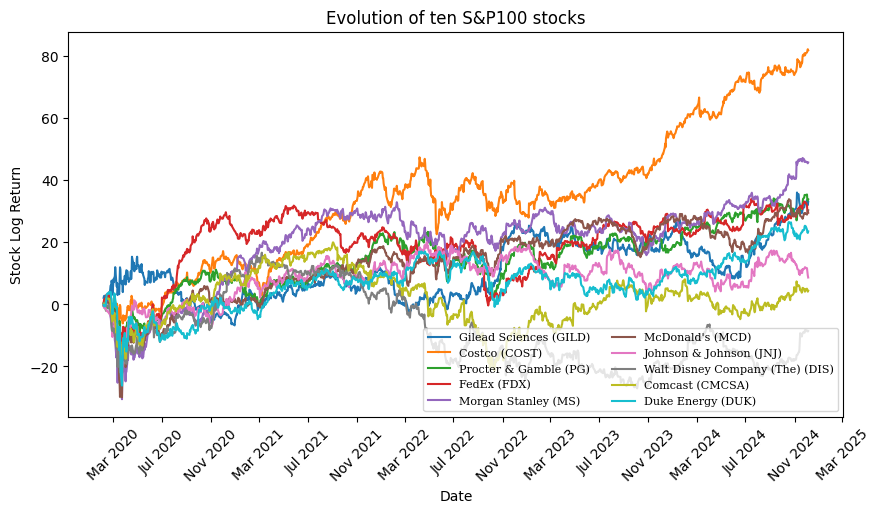

In [18]:
plt.figure(figsize=(10, 5))

for stock in np.random.choice(stocks.index, size=10, replace=False):
	plt.plot(values.loc[stock].index, np.cumsum(values.loc[stock]["DailyLogReturn"]), label=f'{stocks.loc[stock]["Name"]} ({stock})')
plt.title(f"Evolution of ten S&P100 stocks")
plt.xlabel('Date')
plt.gca().tick_params(axis='x', rotation=45)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=4))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.ylabel('Stock Log Return')
plt.legend(ncol=2, loc="lower right", prop={'size': 8, 'family': 'serif'})
plt.show()